# Konuşma Tanıma II: Ses Sınıflandırma
<hr>

### İçerik 
- Öznitelik dersi özet geçilmesi
- Kullanacağımız veri kümesinin incelenmesi
- Sınıflandırma kodunun yazılması

### Veri Kümeleri
- Librispeech https://www.openslr.org/12
- **Common Voice** https://commonvoice.mozilla.org/en

### Derin Öğrenme Mimarisi

<img src="figures/model.png" />

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader

import time
import os
import copy
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

ModuleNotFoundError: No module named 'pandas'

### Veri kümesinin oluşturulması

In [30]:
class VoiceDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_table(csv_path)
        self.df = df.dropna(subset=['gender'])
        
        self.wav_folder = "clips"
        self.classes = {'female': 0, 'male': 1}
        
        self.mel_limit = 256
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        wav_name = self.df.iloc[idx].path
        wav_path = os.path.join(self.wav_folder, wav_name)
        
        label = self.df.iloc[idx].gender
        label = self.classes[label]
        
        feature = self.load_sound(wav_path)
        
        return {'data': feature, 'label': label}
    
    def load_sound(self, path):
        signal, sampling_rate = librosa.load(path, sr=None)
        mel_spectrogram = librosa.feature.melspectrogram(signal, sampling_rate)
        mel_spectrogram = torch.from_numpy(mel_spectrogram)
        
        # padding & cutting
        length = mel_spectrogram.shape[1]
        n_mels = mel_spectrogram.shape[0]
        
        if length < self.mel_limit:
            pad_tensor = torch.zeros((n_mels, self.mel_limit-length))
            mel_spectrogram = torch.cat((mel_spectrogram, pad_tensor), 1)
        mel_spectrogram = mel_spectrogram[:, :self.mel_limit]

        return mel_spectrogram.unsqueeze(0)


train_dataset = VoiceDataset("~/Datasets/common_voice/tr/cv-corpus-5.1-2020-06-22/tr/train.tsv")
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = VoiceDataset("~/Datasets/common_voice/tr/cv-corpus-5.1-2020-06-22/tr/test.tsv")
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

dataloaders= {'train': train_dataloader,
             'val': val_dataloader}
data_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

sample = next(iter(train_dataloader))
print(sample['data'].shape)

torch.Size([64, 1, 128, 256])


### Veri kümesinin incelenmesi

In [31]:
print("number of train sample: {}".format(len(train_dataset)))
print("number of val sample: {}".format(len(val_dataset)))

number of train sample: 1483
number of val sample: 536


In [32]:
#durations = []
#for path in tqdm(train_dataset.df.path):
#    y, sr = librosa.load(os.path.join(train_dataset.wav_folder, path))
#    dur = librosa.get_duration(y, sr)
#    durations.append(dur)
#
#pd.DataFrame(durations).hist()

AxesSubplot(0.125,0.125;0.775x0.755)


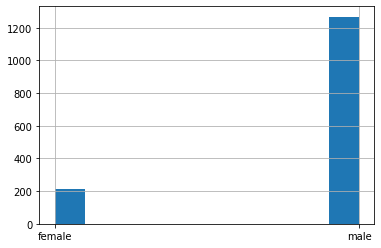

In [33]:
print(train_dataset.df.gender.hist())

### Eğitim

In [34]:
device = torch.device("cuda:0")

In [35]:
class VoiceModel(nn.Module):
    def __init__(self):
        super(VoiceModel, self).__init__()
        
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(59520, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    
    def forward(self, inputs):
        x = self.feature(inputs)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.classifier(x)
        return x

model = VoiceModel().to(device)
print(model)

VoiceModel(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=59520, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(25):
    print(f"Epoch : {epoch}")
    print("-"*10)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        running_loss = 0
        running_corrects = 0
        
        for batch in tqdm(dataloaders[phase]):
            inputs = batch['data'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / data_sizes[phase]
        epoch_acc = running_corrects / data_sizes[phase]
        
        print('loss: {} | accuracy: {}'.format(epoch_loss, epoch_acc))

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch : 0
----------


  0%|          | 0/9 [00:00<?, ?it/s]

loss: 6.6314890483546245 | accuracy: 0.7835469245910645


  0%|          | 0/24 [00:00<?, ?it/s]

loss: 0.3680933642743239 | accuracy: 0.9123134016990662
Epoch : 1
----------


  0%|          | 0/9 [00:00<?, ?it/s]

loss: 0.2577472819280399 | accuracy: 0.8853675127029419


  0%|          | 0/24 [00:00<?, ?it/s]

loss: 0.2567859256445472 | accuracy: 0.9029850363731384
Epoch : 2
----------


 54%|█████▍    | 13/24 [04:41<04:03, 22.16s/it]

### Eğitimin İyileştirilmesi
- Learning rate scheduler
- SGD
- Hyper parameter optimization
- Veri artırma (specAugment)